## Outline
This notebook goes through a CRISP-DM process:
- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results

## Business Understanding
Our purpose is to answer from the Boston Airbnb data:
- Which neighborhoods are more described as quiet, safe and residential?
- Which neighborhoods are strongly claimed to have restaurants, bars and shops?
- Which neighborhoods are claimed nice to go on a walk for having green space, rivers, etc.?

## Data Understanding
We rely on a dataset of Airbnb listings in Boston that includes among others full descriptions and average review score.

From all the columns of the dataset, we will use for each listing:
- **id**: integer - the id of the listing
- **neighbourhood_cleansed**: text - name of the neighborhood of the listing
- **neighborhood_overview**: text - a description (overview) of the neighborhood
- **latitude** and **longitude**: floats - coordinates of the listing

In [81]:
import pandas as pd
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

listing_filename = 'listings.csv'
cols = ['id', 'neighbourhood_cleansed', 'neighborhood_overview', 'latitude', 'longitude']
df = pd.read_csv(listing_filename, usecols=cols)

## Prepare Data

In [82]:
df.count()

id                        3585
neighborhood_overview     2170
neighbourhood_cleansed    3585
latitude                  3585
longitude                 3585
dtype: int64

In [3]:
# From the selected columns, some rows have only their neighborhood_overview text missing.
# Since we gather overviews by neighborhood for this analysis, we do not want redundant or ungenuine overviews.
# Therefore we drop these rows with missing neighborhood_overview values.
df.dropna(inplace=True)

### Prepare sentences composing each neighborhood
    - split to sentences
    - tokenize
    - lemmatize
    - discard stopwords and others

In [4]:
# Import spaCy and load the language library
import spacy
nlp = spacy.load('en_core_web_sm')
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer, before="parser")
doc = nlp("This is a sentence. This is another sentence.")

In [5]:
# Let's first create a function that decides what to exclude of the tokens of the sentence
def is_excluded(token, avoidwords=[]):
    '''
    This function decides whether to include 'token' to the list of lemmas
    INPUT
        token - token object in a doc
        avoidwords - additional words to exclude
    OUTPUT
        is_excluded - boolean - whether to exlude the token to the list of lemmas
    '''
    rules = [token.is_stop,
             token.is_punct,
             token.is_space,
             token.like_num,
             token.lemma_ in avoidwords
            ]
    return any(rules)

In [6]:
# Create a function splits a neighborhood_overview text into sentences, 
# discards some tokens and returns the sentences and the sentences after processing
def prepare_sentences(overview, avoidwords=[]):
    '''
    This function splits a neighborhood_overview text into sentences, 
    discards some tokens and returns the sentences and the sentences after processing
    INPUT
        overview - text from neighborhood_overview
        avoidwords - specific words to exclude
    OUTPUT
        sentences_lemmas - list of sentences of the overview text after processing
        sentences - boolean - list of sentences of the overview text
    '''
    if pd.notnull(overview): # or isinstance(text, str):
        doc = nlp(overview)
        sentences = []
        sentences_lemmas = []
        for sent in doc.sents:
            lemmas = []
            for token in sent:        
                if not is_excluded(token, avoidwords):
                    lemmas.append(token.lemma_)
                sent_lemmas = ' '.join(lemmas)
            if len(sent_lemmas):
                sentences_lemmas.append(sent_lemmas)
                sentences.append(sent.text)
        return sentences_lemmas, sentences
    else:
        print("warning: empty text")
        return [], []

# test
prepare_sentences(u"""Tesla is looking at buying a U.S. startup in Boston for $6 million.
                  Startups are becoming juicy minutes after it.""",
                 avoidwords=['Boston'])

(['Tesla look buy U.S. startup $', 'startup juicy minute'],
 ['Tesla is looking at buying a U.S. startup in Boston for $6 million.',
  '\n                  Startups are becoming juicy minutes after it.'])

In [7]:
# Apply prepare_sentences() to the whole dataset
# Each sentence can be linked to the neighborhood it is about using its index in the list
def prepare_data(dt, avoidwords=[]):
    '''
    This function applies prepare_sentences() to a dataframe
    INPUT
        dt - dataframe including neighbourhood_cleansed and neighborhood_overview
        avoidwords - specific words to exclude
    OUTPUT
        sents_lemmas - list of sentences from the neighborhood overviews after processing
        sents - list of sentences from the neighborhood overviews
        neighborhood_sentids - dictionary neighborhood --> ids of sentences in sents or sents_lemmas to
                               link each sentence in sents (or sents_lemmas) to the neighborhood it is about
    '''
    sents = []
    sents_lemmas = []
    #ntexts = []
    neighborhood_sentids = defaultdict(list)
    last_sentid = 0
    for index, overview, neighbourhood in zip(dt.index, dt.neighborhood_overview, dt.neighbourhood_cleansed):
        sent_lemmas, sent = prepare_sentences(overview, avoidwords)
        sents_lemmas += sent_lemmas
        sents += sent
        neighborhood_sentids[neighbourhood] += [i for i in range(last_sentid, last_sentid+len(sent))]
        last_sentid += len(sent)
    return sents_lemmas, sents, neighborhood_sentids

# test
sents_lemmas, sents, neighborhood_sentids = prepare_data(df.loc[:1, ["neighborhood_overview", 
                                                                     "neighbourhood_cleansed"]])
print("#### sents_lemmas:", sents_lemmas, sep='\n')
print("#### sents:", sents, sep='\n')
print("#### neighborhood_sentids:", neighborhood_sentids, sep='\n')

#### sents_lemmas:
['roslindale quiet convenient friendly', 'southern food try Redd Rozzie', 'Italian Delfino Sophia Grotto great', 'Birch St Bistro nice atmostphere little pricier', 'cook Fish market fresh fish daily Tony make sausage italian food wide variety delicious cheese chocolate Cheese Cellar Birch St.', 'room Roslindale diverse primarily residential neighborhood Boston', 'connect public transportation neighborhood easy access car', 'Roslindale Square nice business district supermarket', 'bank bakery etc', 'Guidebook recommendation', 'Arnold Arboretum step away']
#### sents:
['Roslindale is quiet, convenient and friendly.', " For Southern food try Redd's in Rozzie.", " Italian Delfino's or Sophia's Grotto are great.", 'Birch St Bistro has nice atmostphere--a little pricier.', "  If you are cooking the Fish Market has fresh fish daily; Tony's makes his own sausages and has Italian foods;  for  a wide variety of delicious cheeses and chocolates go to the Cheese Cellar on Birch S

In [8]:
neighborhoods = df["neighbourhood_cleansed"].unique()
X = df[["neighborhood_overview", "neighbourhood_cleansed"]]
# create sentences
# N.B. neighborhood names are excluded for the topics to remain unrelated to the neighborhoods 
sents_lemmas, sents, neighborhood_sentids = prepare_data(X, 
                        avoidwords=['Boston','neighborhood','jp', 'JP'] +' '.join(neighborhoods).split())

## Topic modeling:  Topics extraction from neighborhood overviews

**What the topics are on the neighborhood overviews?**

We will use Latent Dirichlet Allocation (LDA) to extract topics

In [10]:
# First create a document-term matrix 
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(sents_lemmas)

In [11]:
from sklearn.decomposition import LatentDirichletAllocation
nbtopics = 5
LDA = LatentDirichletAllocation(n_components=nbtopics, random_state=42,
                               max_iter=80, evaluate_every=2)
# This can take awhile, we're dealing with a large amount of documents!
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=2, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=80,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [12]:
LDA.n_iter_, LDA.perplexity(dtm)

(43, 709.9403504506598)

In [13]:
# Showing Top Words Per Topic:

for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 20 WORDS FOR TOPIC #{index+1}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]][::-1])
    print('\n')

THE TOP 20 WORDS FOR TOPIC #1
['walk', 'minute', 'downtown', 'close', 'access', 'station', 'easy', 'line', 'city', 'location', 'right', 'away', 'min', 'area', 'stop', 'locate', 'short', 'distance', 'bus', 'public']


THE TOP 20 WORDS FOR TOPIC #2
['restaurant', 'shop', 'walk', 'store', 'bar', 'great', 'street', 'cafe', 'food', 'away', 'block', 'good', 'minute', 'grocery', 'distance', 'coffee', 'italian', 'corner', 'local', 'market']


THE TOP 20 WORDS FOR TOPIC #3
['quiet', 'city', 'diverse', 'area', 'safe', 'family', 'live', 'residential', 'young', 'community', 'great', 'friendly', 'professional', 'people', 'home', 'love', 'student', 'street', 'locate', 'old']


THE TOP 20 WORDS FOR TOPIC #4
['mi', 'mile', 'center', 'museum', 'new', 'hall', 'restaurant', 'university', 'house', 'boston', 'fine', 'england', 'faneuil', 'trail', 'major', 'arts', 'freedom', 'home', 'garden', 'prudential']


THE TOP 20 WORDS FOR TOPIC #5
['street', 'walk', 'park', 'historic', 'beautiful', 'charles', 'river'

In [14]:
# For each neighborhood: How much proportion of the overviews are about topic X ?

topic_results = LDA.transform(dtm)
topic_asgn = topic_results.argmax(axis=1)

d = {**{"neighborhood": list(neighborhood_sentids.keys())}, **{f"topic {i+1}":[] for i in range(nbtopics)}}
d["sentences_count"] = []
d["dominant_topic"] = []
for nghbd, sentids in neighborhood_sentids.items():
    c = np.average(topic_results[sentids], axis=0)
    for i in range(nbtopics):
        d[f"topic {i+1}"].append(c[i])
    d["sentences_count"].append(len(sentids))
    d["dominant_topic"].append(np.argmax(c))
H = pd.DataFrame(d).sort_values(by="sentences_count", ascending=False).round(3)
H.set_index("neighborhood", inplace=True)
H.style.background_gradient(axis=0, subset=list(f"topic {i+1}" for i in range(nbtopics)))

## Results: Comparison between neighborhoods by topic

First, we create functions to get top neighborhoods per question and visualize.

In [42]:
def get_top_neighborhoods(H, topic, max_rank=3):
    """
    Gets top neighborhoods by the proportion of overviews dedicated to a topic
    INPUTS:
        H - dataframe - dataframe of topic proportions by neighborhood
        topic - string - topic of choice e.g. "topic 2"
        max_rank - integer - length of the desired ranking (e.g. max_rank=3 to get top 3 neighborhoods)
    OUTPUT:
        top_neighborhoods - list of the top max_rank neighborhoods
    """
    top_neighborhoods = H[topic].sort_values(ascending=False)
    #top_neighborhoods = list(top_neighborhoods.index[:max_rank])
    #return [(n, H.loc[n, topic]) for n in top_neighborhoods]
    return list(top_neighborhoods.index[:max_rank])

# Test
get_top_neighborhoods(H, "topic 1", max_rank=3)

['Leather District', 'Chinatown', 'South Boston Waterfront']

In [65]:
# Visualize a specific topic importance with a map of 
# listings colored according to the topic proportion in their neighborhood
import plotly.express as px
from IPython.display import Image

def map_topic(df, H, topic):
    """
    Creates a map of listings colored according to the topic proportion in their neighborhood
    INPUTS:
        df - dataframe - dataset of listings
        H - dataframe - dataframe of topic proportions by neighborhood
        topic - string - topic of choice e.g. "topic 2"
        max_rank - integer - length of the desired ranking (e.g. max_rank=3 to get top 3 neighborhoods)
    OUTPUT:
        None
    """
    df[topic] = df["neighbourhood_cleansed"].apply(lambda n: H.loc[n, topic])
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color=topic, 
                            hover_name="neighbourhood_cleansed", zoom=11,
                            center={'lat':42.32,'lon':-71.08}, width=700, height=700,
                            )
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return fig

### Topic 1: About well connected neighborhoods and proximity to downtown

In [67]:
max_rank = 3
topic = "topic 1"

top_neighborhoods = get_top_neighborhoods(H, topic, max_rank=3)
print(f"The top {max_rank} neighborhoods for {topic}:", ', '.join(top_neighborhoods))

The top 3 neighborhoods for topic 1: Leather District, Chinatown, South Boston Waterfront


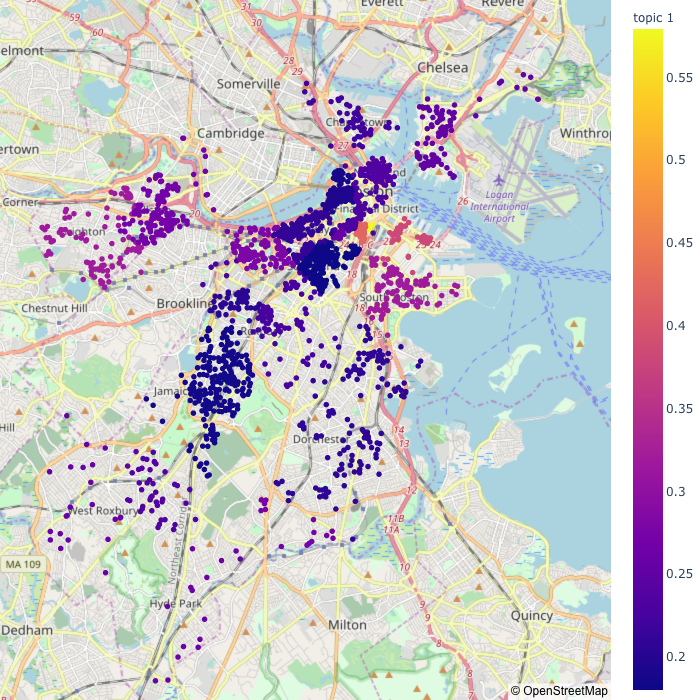

In [68]:
fig = map_topic(df, H, topic)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Topic 2: On having restaurants, bars and shops etc.

In [69]:
max_rank = 3
topic = "topic 2"

top_neighborhoods = get_top_neighborhoods(H, topic, max_rank=3)
print(f"The top {max_rank} neighborhoods for {topic}:", ', '.join(top_neighborhoods))

The top 3 neighborhoods for topic 2: Mattapan, Brighton, Allston


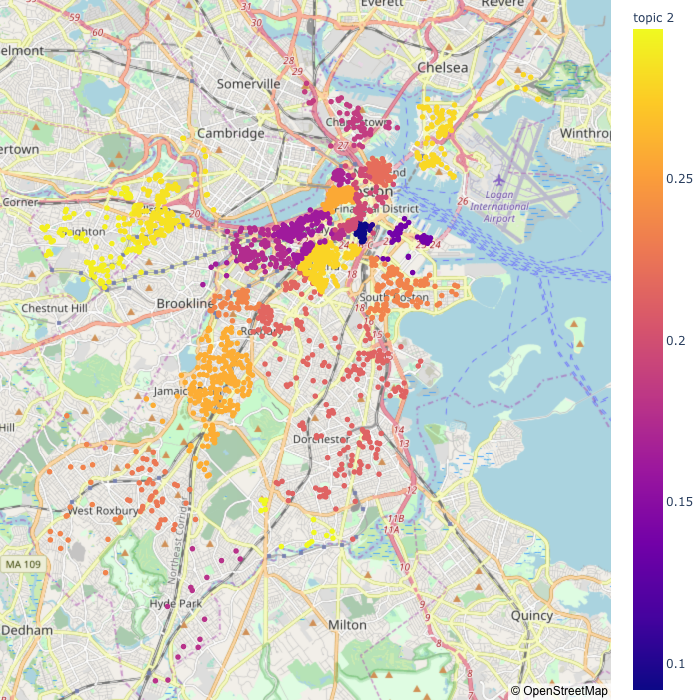

In [70]:
fig = map_topic(df, H, topic)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Topic 3: About quiet, safe and residential neighborhoods

In [71]:
max_rank = 3
topic = "topic 3"

top_neighborhoods = get_top_neighborhoods(H, topic, max_rank=3)
print(f"The top {max_rank} neighborhoods for {topic}:", ', '.join(top_neighborhoods))

The top 3 neighborhoods for topic 3: Longwood Medical Area, Roxbury, Hyde Park


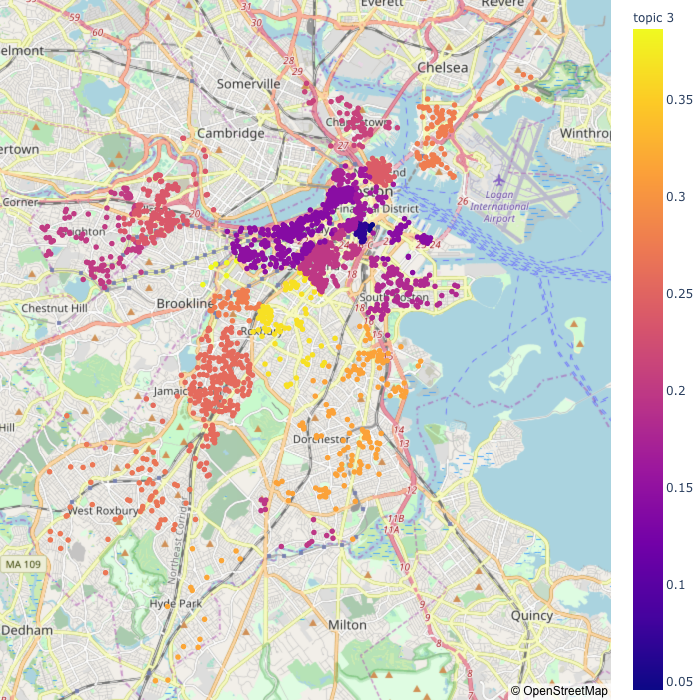

In [72]:
fig = map_topic(df, H, topic)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Topic 4: About museums, art or universities.

In [74]:
max_rank = 3
topic = "topic 4"

top_neighborhoods = get_top_neighborhoods(H, topic, max_rank=3)
print(f"The top {max_rank} neighborhoods for {topic}:", ', '.join(top_neighborhoods))

The top 3 neighborhoods for topic 4: Chinatown, Fenway, Charlestown


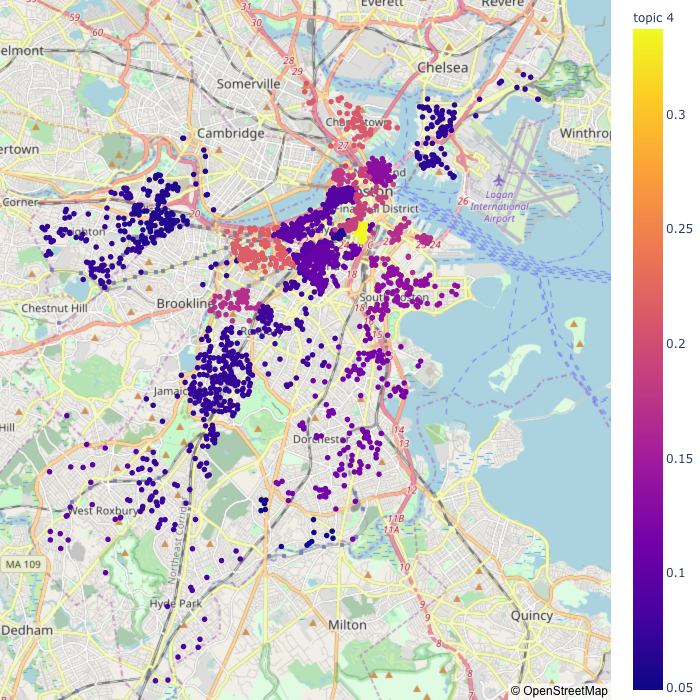

In [75]:
fig = map_topic(df, H, topic)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

### Topic 5: About walking, areas, historic streets, green space, rivers and ponds.

In [76]:
max_rank = 3
topic = "topic 5"

top_neighborhoods = get_top_neighborhoods(H, topic, max_rank=3)
print(f"The top {max_rank} neighborhoods for {topic}:", ', '.join(top_neighborhoods))

The top 3 neighborhoods for topic 5: Back Bay, Beacon Hill, Bay Village


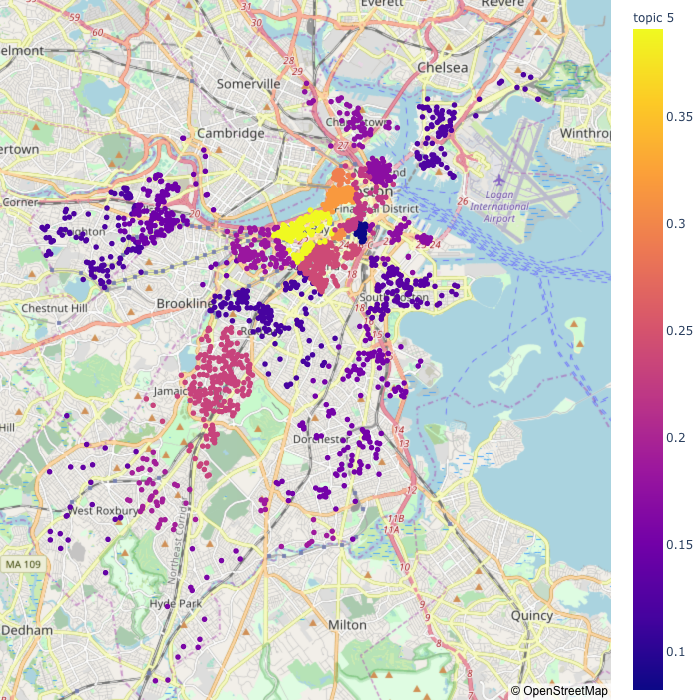

In [77]:
fig = map_topic(df, H, topic)
img_bytes = fig.to_image(format="png")
Image(img_bytes)